In [1]:
import pandas as pd
import numpy as np
import string
import time
import random
import unidecode
import math

import torch
import torch.nn as nn
from torch.autograd import Variable

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
lines = pd.read_csv("the-office-lines-simplified.csv")
characters = {
    "Michael":1,"Dwight":2,"Jim":3,"Pam":4,"Andy":5,"Kevin":6,"Angela":7,
    "Oscar":8,"Erin":9,"Ryan":10,"Darryl":11,"Phyllis":12,"Kelly":13,"Jan":14,"Toby":15,"Other":16
}

characters_inverted = {}
for c in characters:
    characters_inverted[characters[c]] = c
print characters_inverted

all_characters = string.printable
n_characters = len(all_characters)

{1: 'Michael', 2: 'Dwight', 3: 'Jim', 4: 'Pam', 5: 'Andy', 6: 'Kevin', 7: 'Angela', 8: 'Oscar', 9: 'Erin', 10: 'Ryan', 11: 'Darryl', 12: 'Phyllis', 13: 'Kelly', 14: 'Jan', 15: 'Toby', 16: 'Other'}


In [3]:
full_text = ""
for i, line in enumerate(lines['line_text']):
    full_text += characters_inverted[lines['speaker_id'][i]] + ': ' + lines['line_text'][i] + '\n'

In [4]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, rnn_type='GRU'):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        #self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
        if rnn_type in ['LSTM', 'GRU']:
            self.rnn = getattr(nn, rnn_type)(input_size, hidden_size, n_layers)
        else:
            nonlinearity = {'RNN_TANH': 'tanh', 'RNN_RELU': 'relu'}[rnn_type]
            self.rnn = nn.RNN(input_size, hidden_size, n_layers, nonlinearity=nonlinearity)
            
        self.rnn_type = rnn_type
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        if self.rnn_type == 'LSTM':
            weight = next(self.parameters())
            return (weight.new_zeros(self.n_layers, 1, self.hidden_size),
                    weight.new_zeros(self.n_layers, 1, self.hidden_size))
        else: Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [6]:
class RNNModel(nn.Module):
    def __init__(self, ntoken, ninp, nhid, nlayers, rnn_type, dropout=0.5, tie_weights=False):
        super(RNNModel, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        
        if rnn_type in ['LSTM', 'GRU']:
            self.rnn = getattr(nn, rnn_type)(ninp, nhid, nlayers, dropout=dropout)
        else:
            nonlinearity = {'RNN_TANH': 'tanh', 'RNN_RELU': 'relu'}[rnn_type]
            self.rnn = nn.RNN(ninp, nhid, nlayers, nonlinearity=nonlinearity, dropout=dropout)
            
        self.decoder = nn.Linear(nhid, ntoken)

        self.init_weights()

        self.rnn_type = rnn_type
        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters())
        if self.rnn_type == 'LSTM':
            return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                    weight.new_zeros(self.nlayers, bsz, self.nhid))
        else:
            return weight.new_zeros(self.nlayers, bsz, self.nhid)

In [7]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [8]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

def random_chunk():
    start_index = random.randint(0, len(full_text) - chunk_len)
    end_index = start_index + chunk_len + 1
    return full_text[start_index:end_index]

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

chunk_len = 200
print(random_chunk())

t doesn't make sense, couldn't be.
Michael: What is that?  Dwight, are you peeing?
Dwight: I'm peeing in this empty can.
Jim: Oh my God!
Michael: Come on man, that is disgusting Dwight!
Dwight: Well yo


In [9]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [10]:
def plot_loss(all_losses, rnn_type='', c='m'):
    plt.figure()
    plt.title(rnn_type)
    plt.xlabel('epoch number')
    plt.ylabel('loss')
    plt.plot(all_losses, color=c)
    plt.show()

 14s (100 0%) 2.4737]
 28s (200 0%) 2.4159]
 43s (300 0%) 2.2332]
 57s (400 0%) 2.2809]
 11s (500 0%) 2.2228]
 25s (600 0%) 1.8723]
 40s (700 0%) 1.8858]
 55s (800 0%) 1.7242]
 9s (900 0%) 1.7769]
 24s (1000 100%) 1.4710]


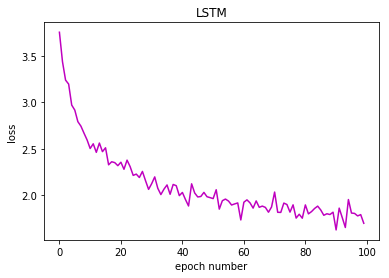

 14s (100 0%) 2.1968]
 29s (200 0%) 1.6629]
 44s (300 0%) 1.7266]
 59s (400 0%) 1.9324]
 14s (500 0%) 2.1064]
 28s (600 0%) 1.6529]
 43s (700 0%) 1.3720]
 58s (800 0%) 1.5923]
 12s (900 0%) 2.2256]
 27s (1000 100%) 1.8227]


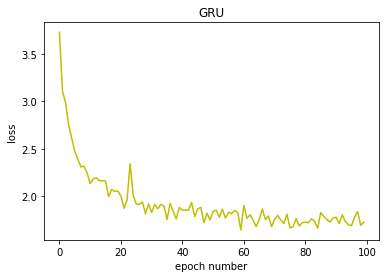

 19s (100 0%) 2.3835]
 37s (200 0%) 1.7845]
 49s (300 0%) 1.9426]
 56s (400 0%) 1.8136]
 3s (500 0%) 1.7203]
 10s (600 0%) 1.8103]
 16s (700 0%) 1.5164]
 27s (800 0%) 1.5490]
 46s (900 0%) 1.3495]
 6s (1000 100%) 1.6048]


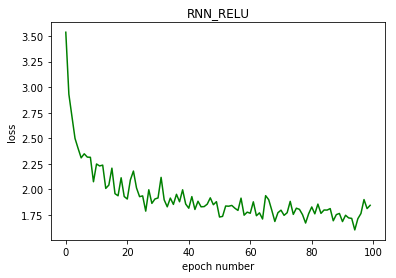

 9s (100 0%) 2.1926]
 18s (200 0%) 2.0673]
 25s (300 0%) 1.6940]
 34s (400 0%) 1.9584]
 42s (500 0%) 2.0783]
 51s (600 0%) 1.7938]
 59s (700 0%) 1.9628]
 7s (800 0%) 1.7388]
 16s (900 0%) 1.8755]
 25s (1000 100%) 1.6311]


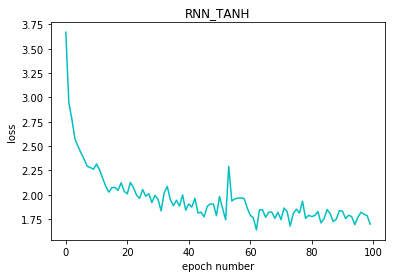

In [15]:
n_epochs = 1000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 2
lr = 0.005
verbose = 1

times_collection = {}
loss_collection = {}

rnn_types = ['LSTM', 'GRU', 'RNN_RELU', 'RNN_TANH']

for i, rnn_type in enumerate(rnn_types):
    decoder = RNN(n_characters, n_characters, hidden_size, n_layers, rnn_type)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    start = time.time()
    all_losses = []
    loss_avg = 0
    
    times_collection[rnn_type] = []
    loss_collection[rnn_type] = []

    for epoch in range(1, n_epochs + 1):
        loss = train(*random_training_set())       
        loss_avg += loss
        
        if epoch % print_every == 0 :
            if verbose > 0: print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
            if verbose > 1: print evaluate('M', 400) + '\n'

        if epoch % plot_every == 0:
            all_losses.append(loss_avg / plot_every)
            loss_collection[rnn_type].append(float(loss_avg) / float(plot_every))
            loss_avg = 0
        
        if epoch % (plot_every*4) == 0: 
            start2 = time.time()
            times_collection[rnn_type].append(time.time() - start2)

    plot_loss(all_losses, rnn_type, ['m', 'y', 'g', 'c'][i])

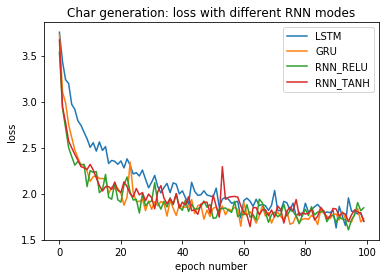

In [19]:
plt.figure()
plt.title('Char generation: loss with different RNN modes')
plt.xlabel('epoch number')
plt.ylabel('loss')
for rnn_type in rnn_types:
    plt.plot(loss_collection[rnn_type])

plt.legend(rnn_types)
plt.show()

In [13]:
print evaluate('Andy', 200)

Andy: I mane, my beguace, and this don't could. I can is mistet her waso, a cack can some you was what's That? I's the don't are the baile. [grichael] Har.
Michael: Shouldustally besway in got thinks for 
